In [ ]:
# Commented out IPython magic to ensure Python compatibility.
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

"""# Get the Data

## Download the Data
"""

import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
Saving figure attribute_histogram_plots


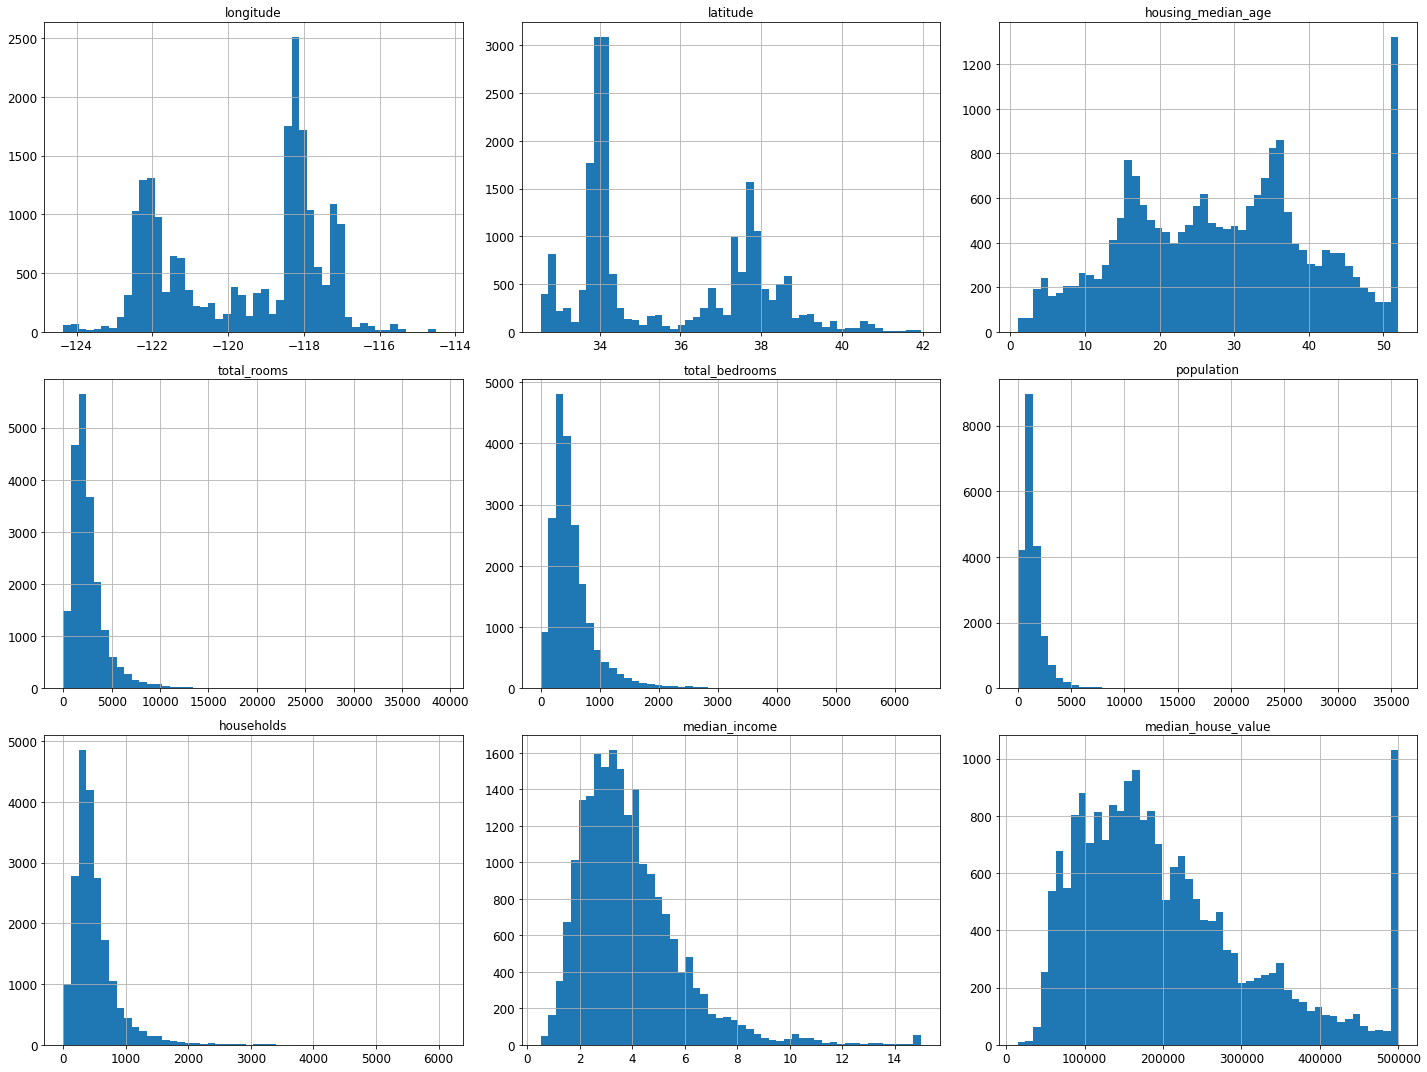

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

"""## Take a Quick Look at the Data Structure"""

housing = load_housing_data()
housing.head()

housing.info()

housing["ocean_proximity"].value_counts()

housing.describe()

# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [ ]:
"""## Create a Test Set"""

# to make this notebook's output identical at every run
np.random.seed(42)

import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

len(test_set)

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

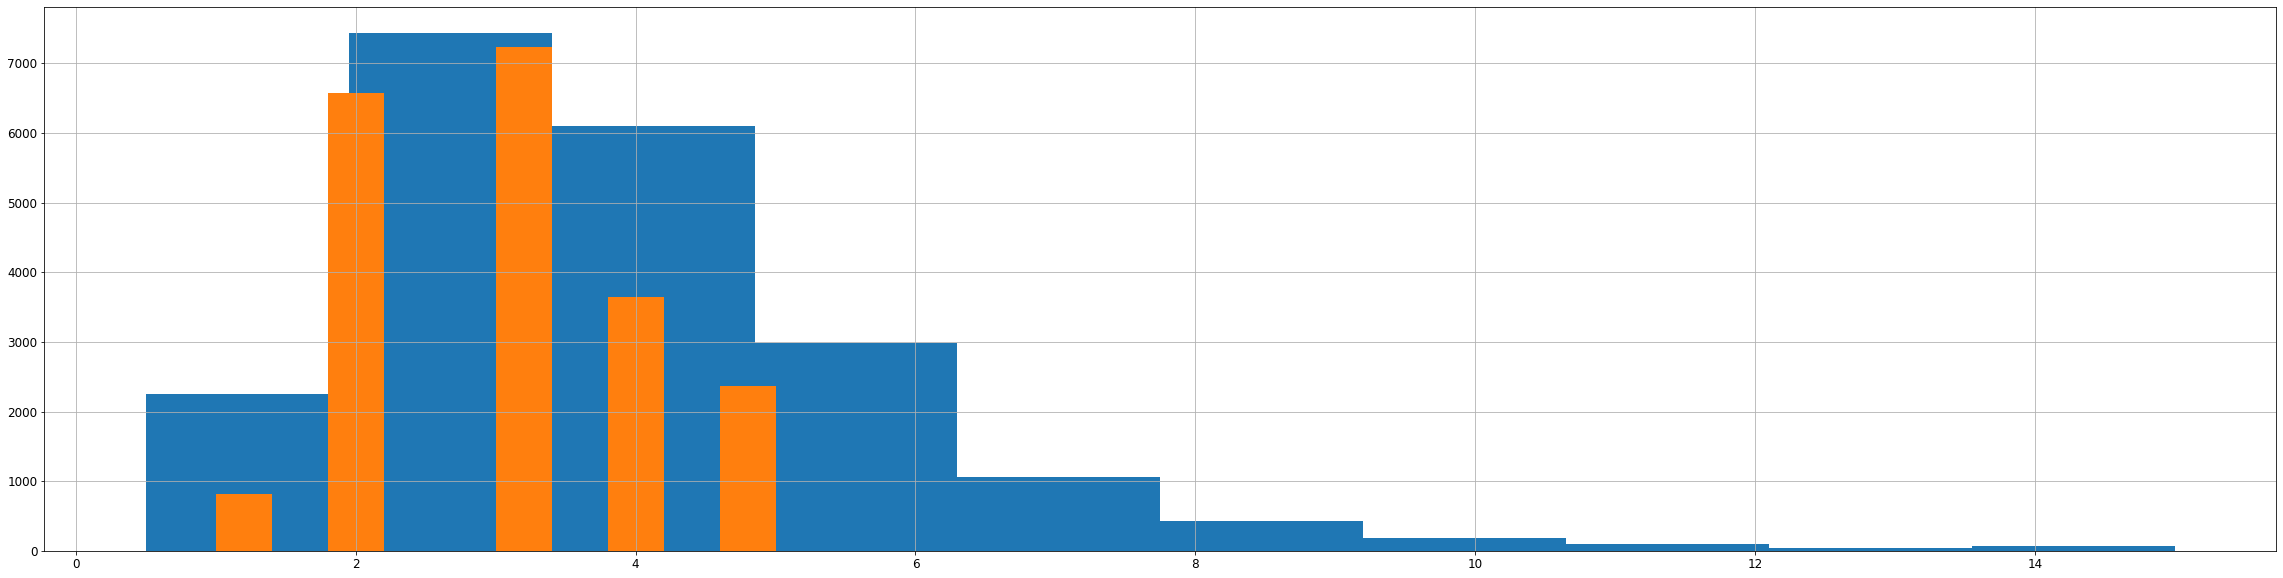

In [ ]:
"""The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:"""

import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

"""If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:"""

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

test_set.head()

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

test_set.head()

housing["median_income"].hist()

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts()

housing["income_cat"].hist()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

housing["income_cat"].value_counts() / len(housing)

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


Saving figure bad_visualization_plot
Saving figure better_visualization_plot
Saving figure housing_prices_scatterplot


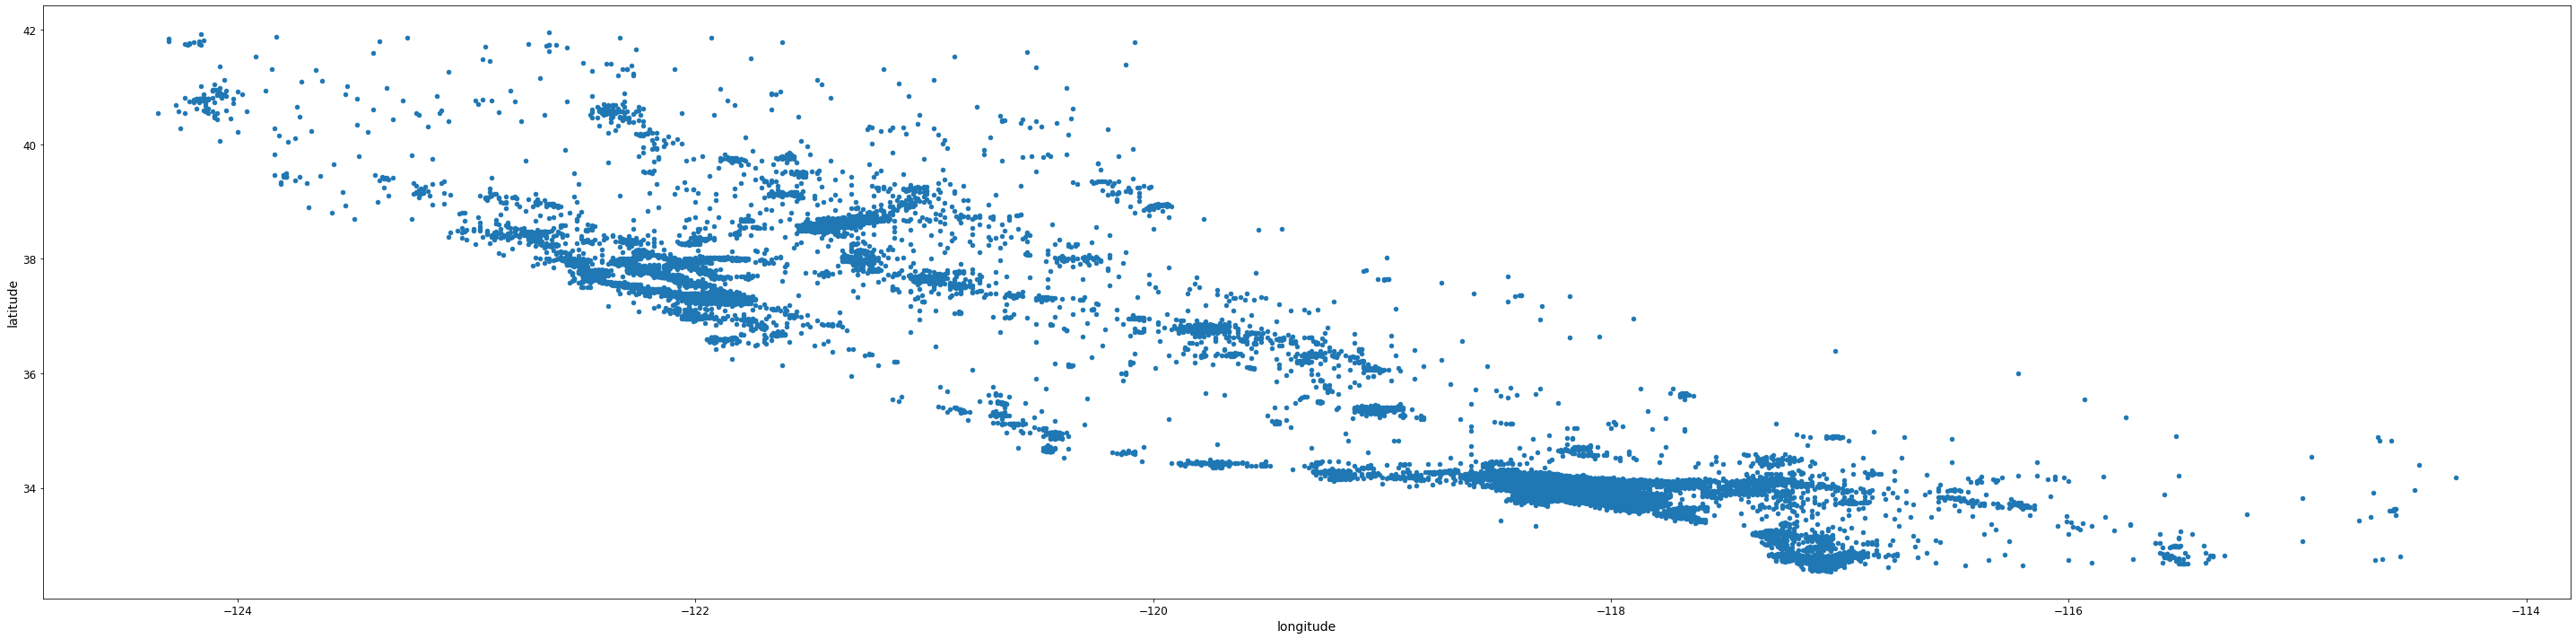

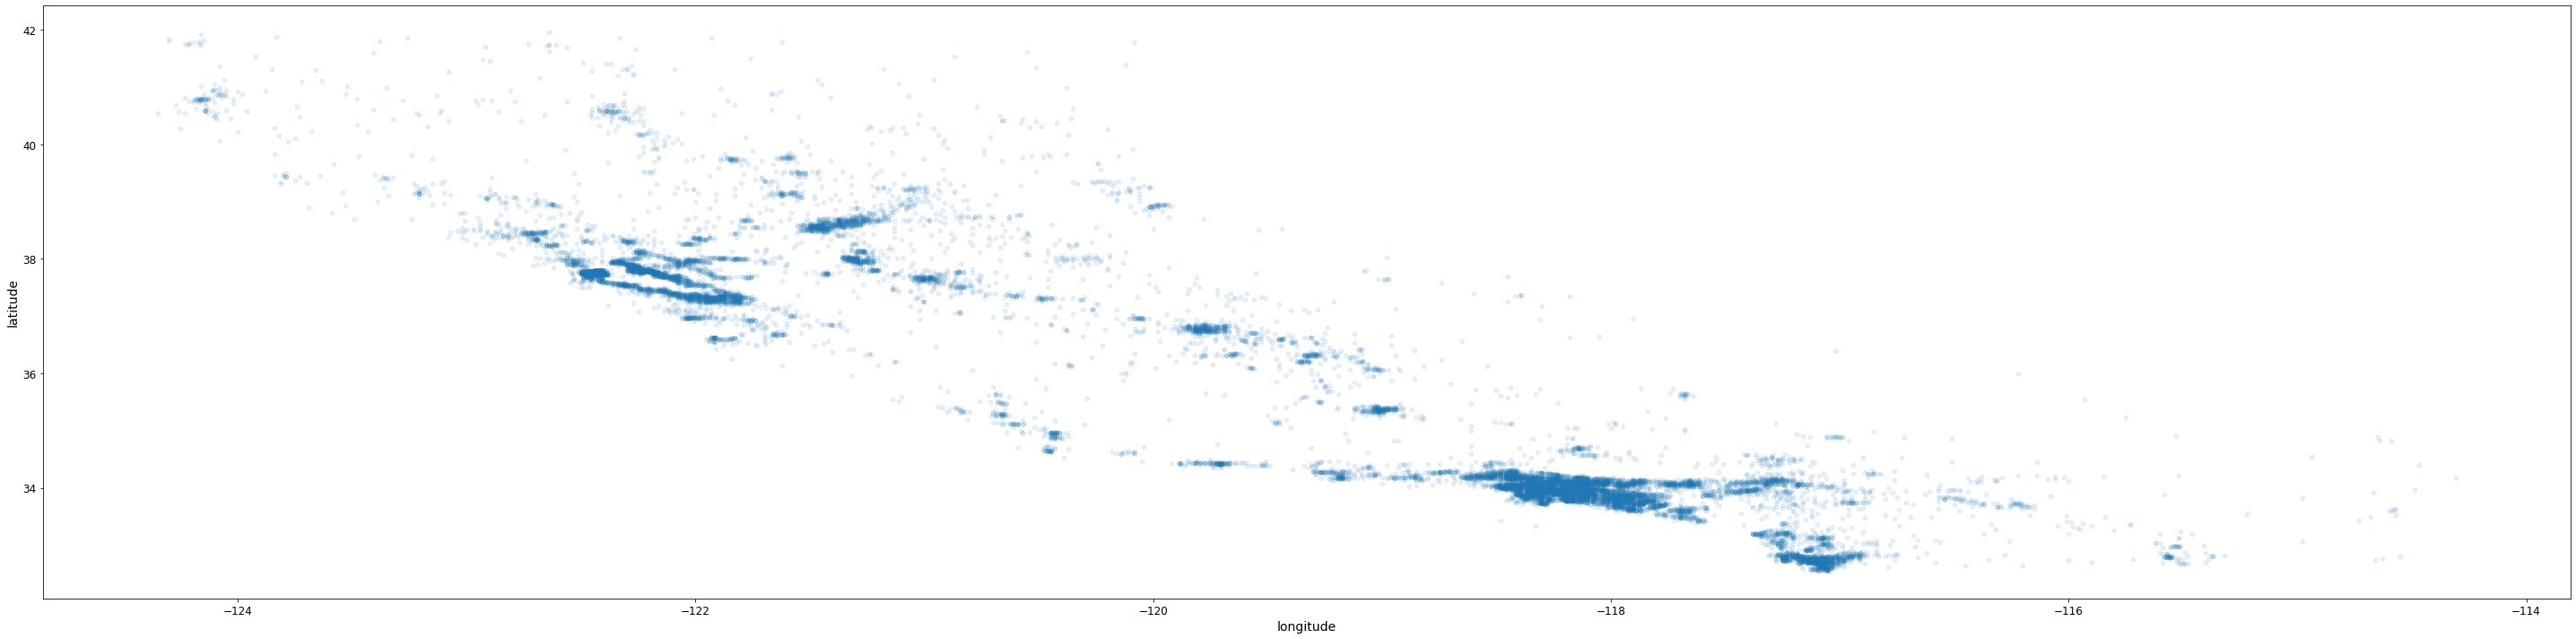

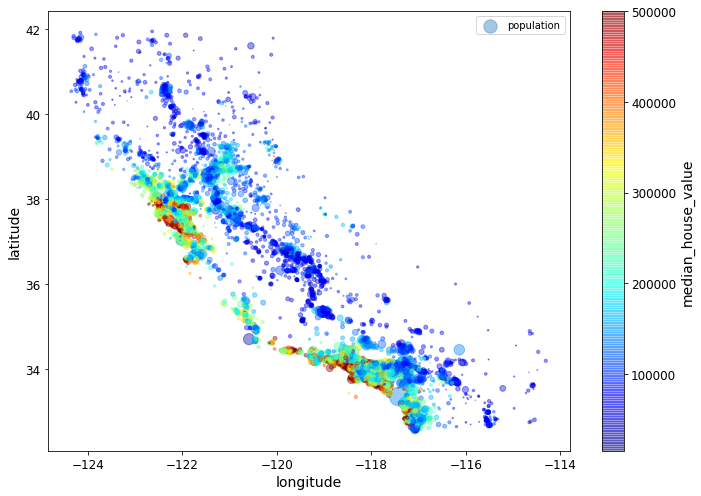

In [ ]:

"""# Discover and Visualize the Data to Gain Insights"""

housing = strat_train_set.copy()

"""## Visualizing Geographical Data"""

housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

"""The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out."""

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")


Saving figure california_housing_prices_plot


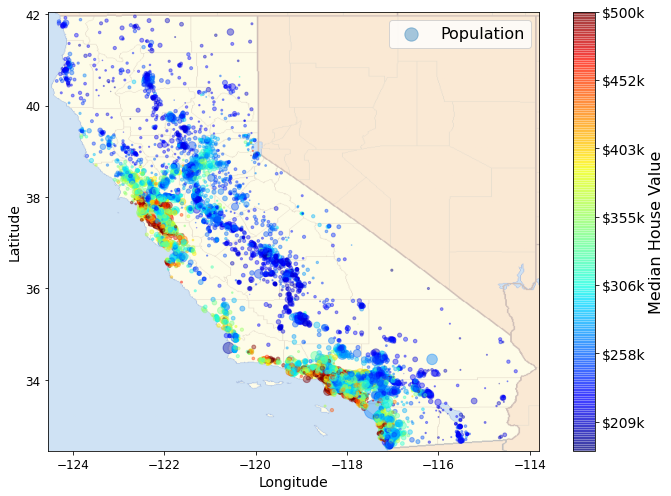

In [ ]:

# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

Saving figure scatter_matrix_plot
Saving figure income_vs_house_value_scatterplot


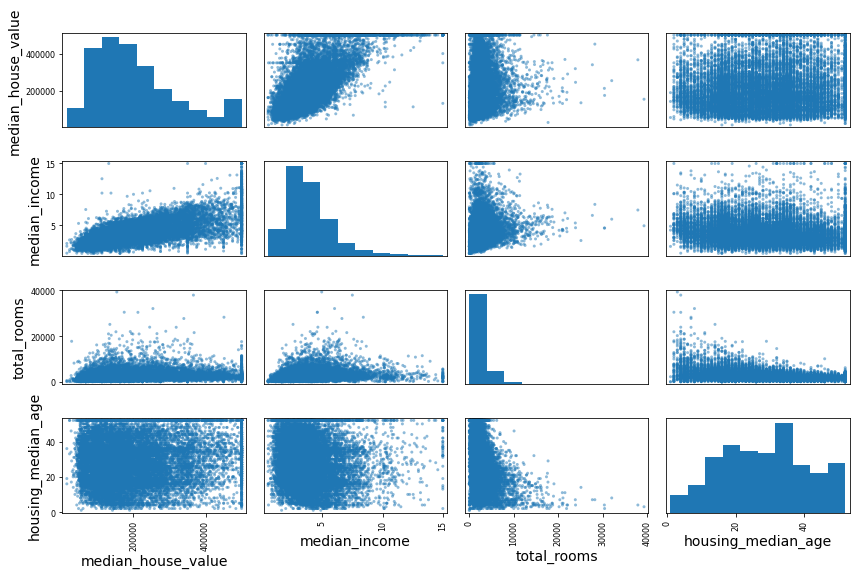

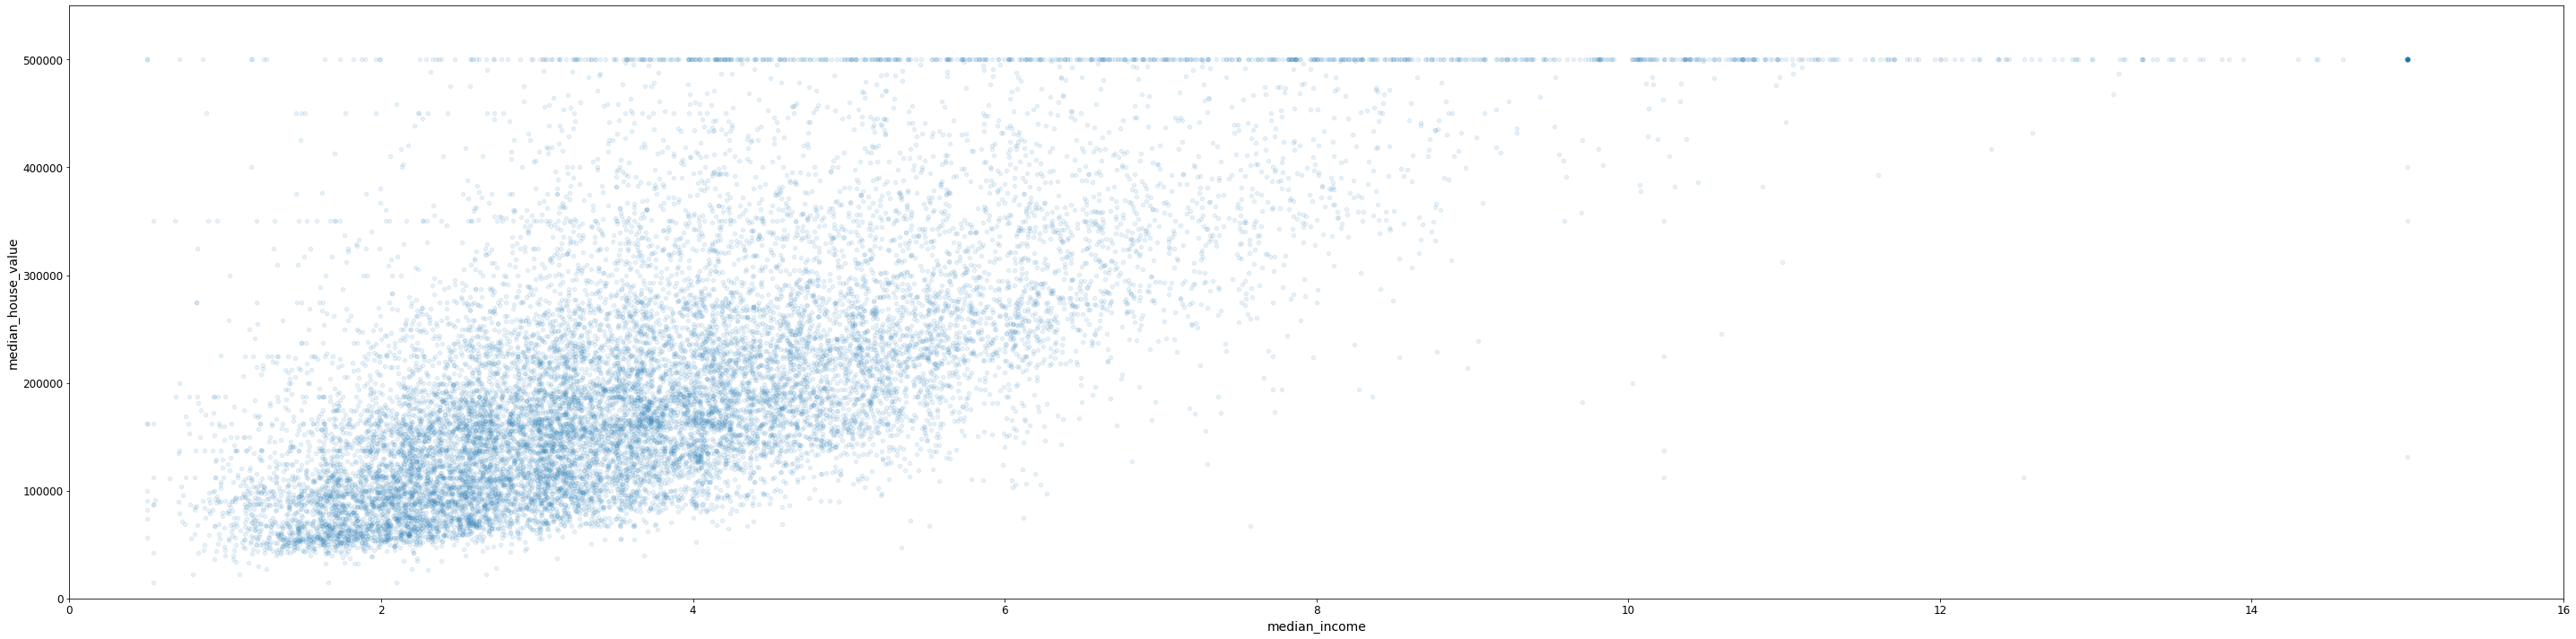

In [ ]:

"""## Looking for Correlations"""

corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")


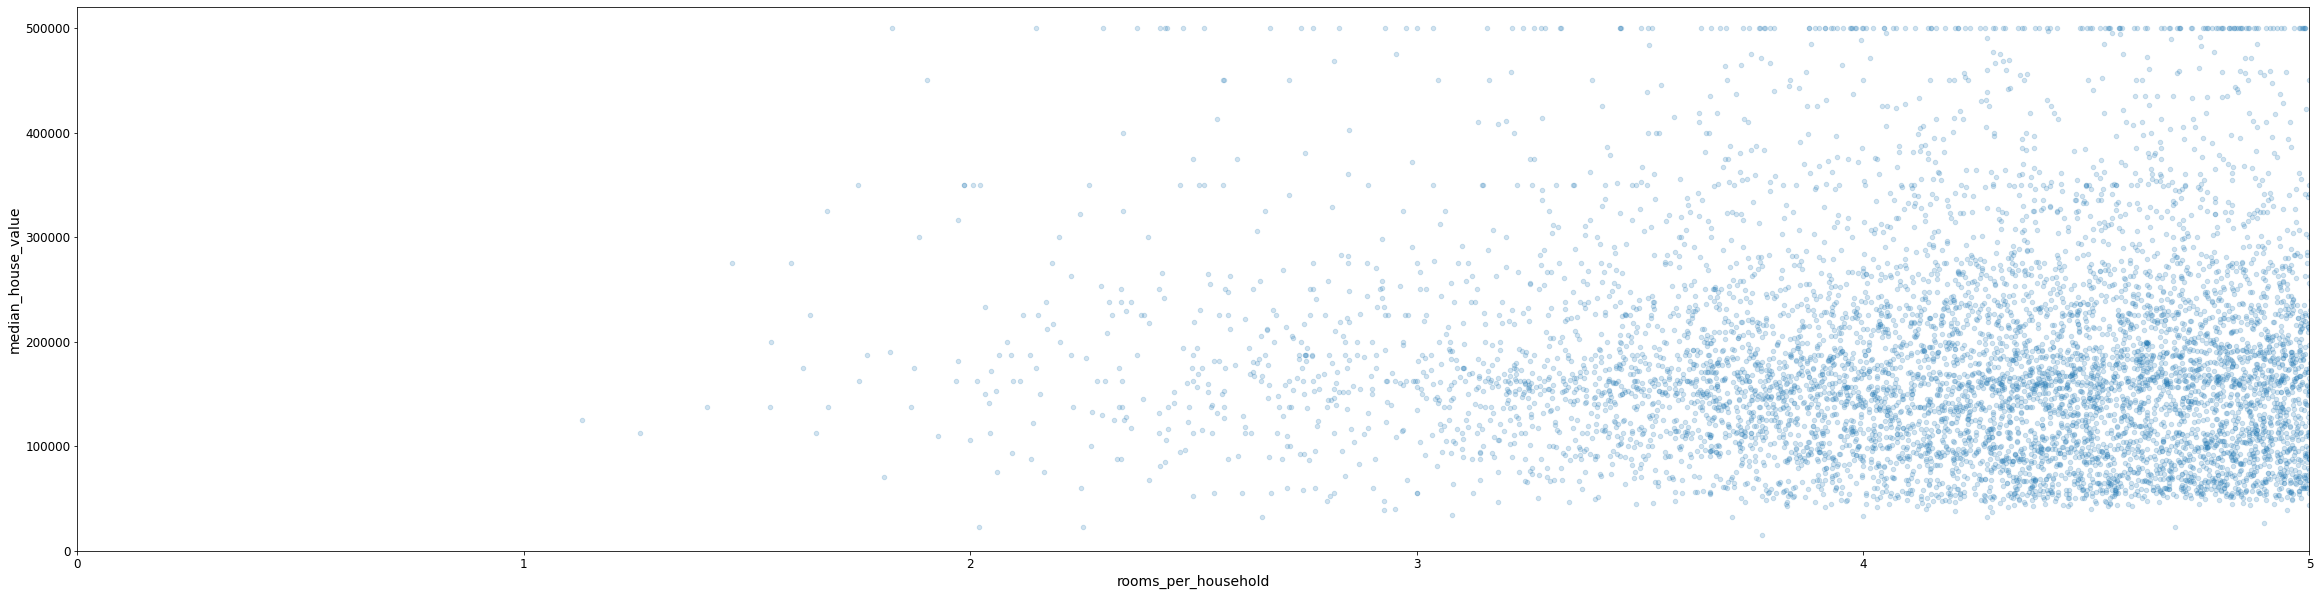

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [ ]:
"""## Experimenting with Attribute Combinations"""

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

housing.describe()

In [ ]:
"""# Prepare the Data for Machine Learning Algorithms"""

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()


In [ ]:
"""## Data Cleaning

In the book 3 options are listed:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:
"""

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

sample_incomplete_rows

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")


In [ ]:
"""Remove the text attribute because median can only be calculated on numerical attributes:"""

housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

imputer.statistics_

"""Check that this is the same as manually computing the median of each attribute:"""

housing_num.median().values

"""Transform the training set:"""

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

housing_tr.loc[sample_incomplete_rows.index.values]

imputer.strategy

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [ ]:
"""## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:
"""

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

ordinal_encoder.categories_

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
"""By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:"""

housing_cat_1hot.toarray()

"""Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:"""

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

cat_encoder.categories_

"""## Custom Transformers

Let's create a custom transformer to add extra attributes:
"""

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
"""Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:"""

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

"""Also, `housing_extra_attribs` is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a `DataFrame`, you could run this:"""

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


In [ ]:
"""## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:
"""

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

housing_prepared.shape

(16512, 16)

In [ ]:
"""For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:"""

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

"""Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:"""

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared


array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
"""The result is the same as with the `ColumnTransformer`:"""

np.allclose(housing_prepared, old_housing_prepared)

"""# Select and Train a Model

## Training and Evaluating on the Training Set
"""

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [ ]:
"""Compare against the actual values:"""

print("Labels:", list(some_labels))

some_data_prepared

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


68627.87390018745

In [ ]:
"""**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`."""

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [ ]:
"""## Better Evaluation Using Cross-Validation"""

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180644


Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606
Scores: [68813.3993301  83178.17296742 70915.38578773]
Mean: 74302.31936175143
Standard deviation: 6334.570213729821
결정 트리의 정확률= 0.04893410852713178


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

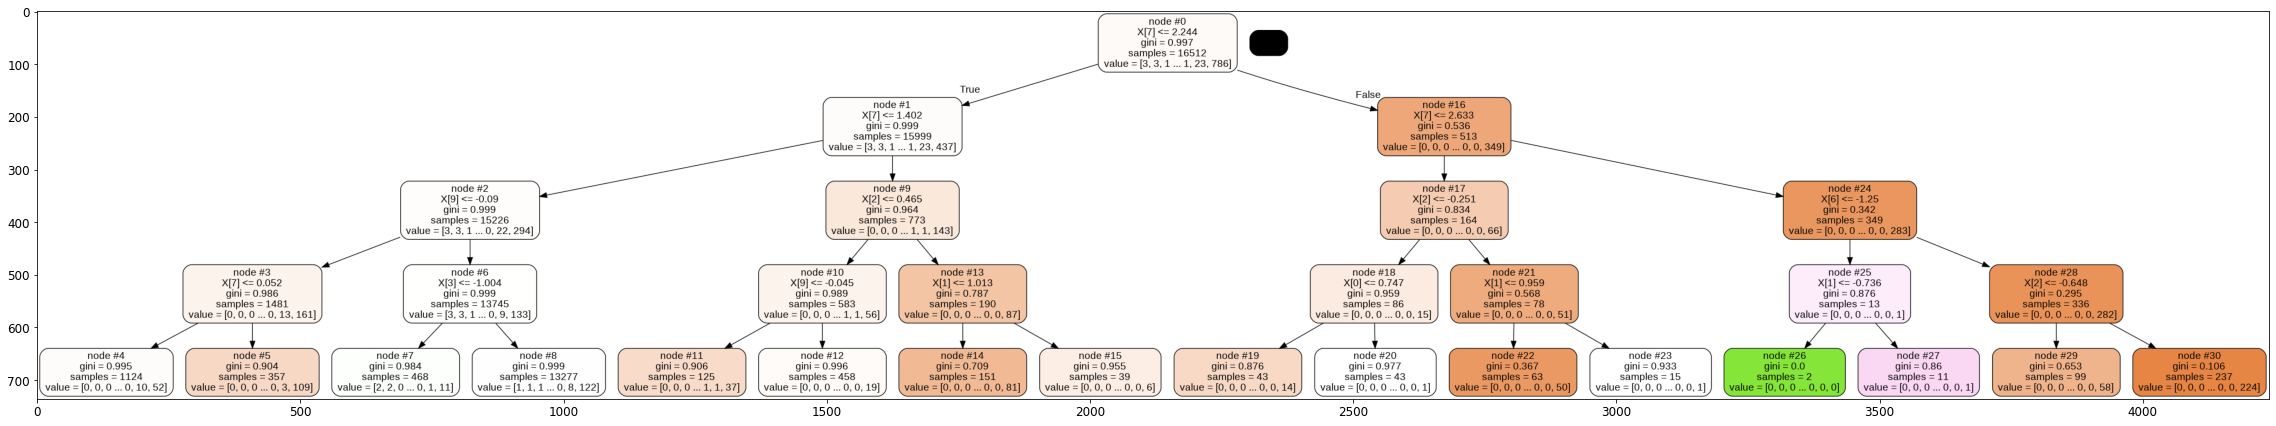

(16512, 16) (16,) (16512,)


In [ ]:
"""**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book)."""

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

from sklearn.svm import SVR

svm_reg = SVR(C=30000, kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=3)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

from sklearn.datasets import load_breast_cancer
from sklearn import tree
import pydotplus

decision_tree=tree.DecisionTreeClassifier(max_depth=4,random_state=1) #변경: 최대깊이를 4로 설정
dt=decision_tree.fit(housing_prepared, housing_labels) # 결정 트리 학습 

res=dt.predict(housing_prepared)
print('결정 트리의 정확률=',sum(res==housing_labels)/len(res)) # 예측

dot=tree.export_graphviz(dt,out_file=None,filled=True,node_ids=True,rounded=True)
graph=pydotplus.graph_from_dot_data(dot)

graph.write_png('tree.png') # 결정 트리를 위한 그림 저장


img = mpimg.imread('tree.png')

from google.colab import files
plt.savefig("./tree.png")
files.download("./tree.png") 

plt.rcParams["figure.figsize"] = (40,10) # to increase image size
plt.imshow(img)
plt.show()

input_shape = housing_prepared.shape[1:]
print(housing_prepared.shape, input_shape, housing_labels.shape)

In [ ]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)
import random

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD,Adam,Adagrad,RMSprop
print(tf.__version__)

2.8.0


In [ ]:
### WARN: Must have ###
# to make this notebook's output stable across runs
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)
   os.environ['TF_DETERMINISTIC_OPS'] = '1'
   
reset_random_seeds()

from tensorflow.python.ops.init_ops_v2 import Initializer
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Input

# Mine
def run_proposed_model(x_train, y_train):  
    reset_random_seeds()  
    
    model_input=Input(shape=(16)) 
    x=BatchNormalization()(model_input)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    model_output=Dense(1)(x)

    model=Model(model_input, model_output)
    model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])
    
    model.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1)
    return model

model = run_proposed_model(housing_prepared, housing_labels)
model.summary()
housing_predictions =  model.predict(housing_prepared)

mlp_mse = mean_squared_error(housing_labels, housing_predictions)
mlp_rmse = np.sqrt(mlp_mse)
print(mlp_rmse)

Epoch 1/100
258/258 [==============================] - 1s 3ms/step - loss: 30416674816.0000 - accuracy: 0.0000e+00
Epoch 2/100
258/258 [==============================] - 1s 3ms/step - loss: 5473714688.0000 - accuracy: 0.0000e+00
Epoch 3/100
258/258 [==============================] - 1s 3ms/step - loss: 4855996416.0000 - accuracy: 0.0000e+00
Epoch 4/100
258/258 [==============================] - 1s 3ms/step - loss: 4606147072.0000 - accuracy: 0.0000e+00
Epoch 5/100
258/258 [==============================] - 1s 3ms/step - loss: 4469955584.0000 - accuracy: 0.0000e+00
Epoch 6/100
258/258 [==============================] - 1s 3ms/step - loss: 4428041216.0000 - accuracy: 0.0000e+00
Epoch 7/100
258/258 [==============================] - 1s 3ms/step - loss: 4334418944.0000 - accuracy: 0.0000e+00
Epoch 8/100
258/258 [==============================] - 1s 3ms/step - loss: 4307796480.0000 - accuracy: 0.0000e+00
Epoch 9/100
258/258 [==============================] - 1s 3ms/step - loss: 4183193344.0

In [ ]:
# baseline VS mine
print('Baseline {} under GPU {}'.format(mlp_rmse, tf.test.is_gpu_available()))

input_shape = housing_prepared.shape[1:]
print(housing_prepared.shape, input_shape, housing_labels.shape)

housing_reduced = np.delete(housing_prepared, [4,5,8,10,11,12,13,14,15], axis=1)
input_shape = housing_reduced.shape[1:]
print(housing_reduced.shape, input_shape, housing_labels.shape)

Baseline 70329.446886448 under GPU True
(16512, 16) (16,) (16512,)
(16512, 7) (7,) (16512,)


In [ ]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)
import random

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD,Adam,Adagrad,RMSprop
print(tf.__version__)

2.8.0


In [ ]:
### WARN: Must have ###
# to make this notebook's output stable across runs
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)
   os.environ['TF_DETERMINISTIC_OPS'] = '1'
   
reset_random_seeds()

from tensorflow.python.ops.init_ops_v2 import Initializer
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Input

he = keras.initializers.HeNormal()
# Mine
def run_proposed_model(x_train, y_train):  
    reset_random_seeds()  
    
    model_input=Input(shape=(7)) 
    x=BatchNormalization()(model_input)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    model_output=Dense(1)(x)

    model=Model(model_input, model_output)
    model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])
    
    model.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1)
    return model

model = run_proposed_model(housing_reduced, housing_labels)
model.summary()
housing_predictions =  model.predict(housing_reduced)

pro_mse = mean_squared_error(housing_labels, housing_predictions)
pro_rmse = np.sqrt(pro_mse)
print(pro_rmse)

Epoch 1/100
258/258 [==============================] - 1s 3ms/step - loss: 25944602624.0000 - accuracy: 0.0000e+00
Epoch 2/100
258/258 [==============================] - 1s 3ms/step - loss: 5238063616.0000 - accuracy: 0.0000e+00
Epoch 3/100
258/258 [==============================] - 1s 3ms/step - loss: 4709710848.0000 - accuracy: 0.0000e+00
Epoch 4/100
258/258 [==============================] - 1s 3ms/step - loss: 4500287488.0000 - accuracy: 0.0000e+00
Epoch 5/100
258/258 [==============================] - 1s 3ms/step - loss: 4433828352.0000 - accuracy: 0.0000e+00
Epoch 6/100
258/258 [==============================] - 1s 3ms/step - loss: 4429988864.0000 - accuracy: 0.0000e+00
Epoch 7/100
258/258 [==============================] - 1s 3ms/step - loss: 4384444928.0000 - accuracy: 0.0000e+00
Epoch 8/100
258/258 [==============================] - 1s 3ms/step - loss: 4383207424.0000 - accuracy: 0.0000e+00
Epoch 9/100
258/258 [==============================] - 1s 3ms/step - loss: 4283847936.0

In [ ]:
# baseline VS mine
print('Baseline {} under GPU {}'.format(pro_rmse, tf.test.is_gpu_available()))

# baseline vs SVM vs Proposed
print('SVM: {}, Baseline: {}, Proposed: {}'.format(
    np.sqrt(-svm_scores.mean()), mlp_rmse, pro_rmse))
print('Proposed / Baseline: {}%, Proposed / SVM: {}%'.format( 
    pro_rmse / mlp_rmse * 100, pro_rmse / np.sqrt(-svm_scores.mean()) * 100))
print("Shape of train dataset:", housing_prepared.shape, housing_reduced.shape)

Baseline 69372.53249696153 under GPU True
SVM: 74571.85422348283, Baseline: 70329.446886448, Proposed: 69372.53249696153
Proposed / Baseline: 98.63938302965545%, Proposed / SVM: 93.02776928284557%
Shape of train dataset: (16512, 16) (16512, 7)


In [ ]:
print("python version", sys.version)
print("TF version", tf.__version__)
if tf.test.is_gpu_available():
    print("GPU available")
else:
    print("GPU unavailable")

python version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TF version 2.8.0
GPU available
